In [254]:
import struct
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

dpi=100

In [255]:
path = "../hydraulic_model/runs/dam_break/"

In [256]:
filename = path+"run_short.dat"

In [257]:
def header(file):
    struct.unpack('i',file.read(4))
    
def unpack_float(file, dims=(1)):
    if dims==(1):
        return struct.unpack('d',file.read(8))[0]
    else:
        dtype = np.dtype(np.float64)
        dtype = dtype.newbyteorder('<')
        return np.frombuffer(file.read(8*np.product(dims))).reshape(dims)

def unpack_int(file):
    return struct.unpack('i',file.read(4))[0]

class channel():
    pass
    
with open(filename, mode="rb") as file:
    header(file)
    channel.nout = unpack_int(file)
    channel.tend = unpack_float(file)
    header(file)
    header(file)
    channel.mx = unpack_int(file)
    channel.my = unpack_int(file)
    channel.meqn = unpack_int(file)
    channel.mbc = unpack_int(file)
    header(file)
    header(file)
    channel.dt = unpack_float(file)
    channel.dx = unpack_float(file)
    channel.dy = unpack_float(file)
    gamma = unpack_float(file)
    channel.cf = unpack_float(file)
    channel.cb = unpack_float(file)
    header(file)
    header(file)
    channel.ixbc = unpack_int(file)
    channel.iybc = unpack_int(file)
    header(file)
    header(file)
    channel.x = unpack_float(file, dims=(channel.mx,1))
    header(file)
    header(file)
    channel.y = unpack_float(file, dims=(channel.my,1))
    header(file)
    header(file)
    channel.h = unpack_float(file, dims=(channel.my,channel.mx))
    header(file)
    header(file)
    channel.cbxy = unpack_float(file, dims=(channel.my,channel.mx))
    header(file)
    
    channel.t = np.zeros((channel.nout))
    channel.d = np.zeros((channel.nout, channel.my, channel.mx))
    channel.qu = np.zeros((channel.nout, channel.my, channel.mx))
    channel.qv = np.zeros((channel.nout, channel.my, channel.mx))
    
    for i in range(channel.nout):
        try:
            header(file)
            channel.t[i] = unpack_float(file)
            header(file)
            header(file)
            channel.d[i,:,:] = unpack_float(file, dims=(channel.my,channel.mx))
            header(file)
            header(file)
            channel.qv[i,:,:] = unpack_float(file, dims=(channel.my,channel.mx))
            header(file)
            header(file)
            channel.qu[i,:,:] = unpack_float(file, dims=(channel.my,channel.mx))
            header(file)
        except:
            print("Broken file")
            break
    
    temporary = np.copy(channel.x[:,0][np.newaxis,:]) 
    channel.x = channel.y[:,0][:,np.newaxis] # swap conventions
    channel.y = temporary # swap conventions
    
    channel.u = channel.qu/channel.d
    channel.v = channel.qv/channel.d
    mask_depth = 1e-16
    channel.u[channel.d <= mask_depth] = np.nan
    channel.v[channel.d <= mask_depth] = np.nan
    channel.qu[channel.d <= mask_depth] = np.nan
    channel.qv[channel.d <= mask_depth] = np.nan
    channel.d[channel.d <= mask_depth] = np.nan
    channel.η = channel.d + channel.h
    channel.η[channel.d <= mask_depth] = np.nan
    

# Plotting equilibrium state

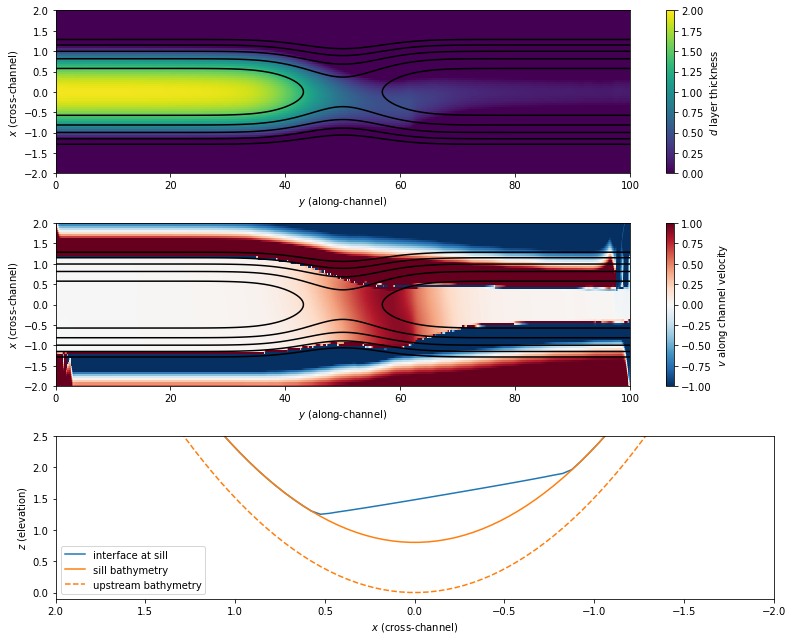

In [267]:
i = 30
plt.figure(1,figsize=(11,9))
plt.clf()
plt.subplot(3,1,1)
q = plt.pcolor(channel.y,channel.x,channel.d[i,:,:])
plt.contour(channel.y.squeeze(),channel.x.squeeze(),channel.h,levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$d$ layer thickness')
q.set_clim([0,2.0])
plt.ylim([-2,2])
plt.ylabel(r"$x$ (cross-channel)")
plt.xlabel(r"$y$ (along-channel)")

plt.subplot(3,1,2)
q = plt.pcolor(channel.y, channel.x, channel.v[i,:,:], cmap=plt.get_cmap("RdBu_r"))
plt.contour(channel.y.squeeze(), channel.x.squeeze(), channel.h, levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$v$ along channel velocity')
q.set_clim([-1,1])
plt.ylim([-2,2])
plt.ylabel(r"$x$ (cross-channel)")
plt.xlabel(r"$y$ (along-channel)")

plt.subplot(3,1,3)
nyhalf = np.int64(channel.y.size/2.)
plt.plot(channel.x,channel.η[i,:,nyhalf],"C0-",label='interface at sill')
plt.plot(channel.x,channel.h[:,nyhalf],"C1-",label='sill bathymetry')
plt.plot(channel.x,channel.h[:,0],"C1--",label='upstream bathymetry')
plt.xlim([2,-2.])
plt.ylim([-0.1,2.5])
plt.legend()
plt.xlabel(r"$x$ (cross-channel)")
plt.ylabel(r"$z$ (elevation)")
plt.tight_layout()
plt.savefig("../figures/faroe_bank_dam_break.png", bbox_inches='tight', dpi=150.)

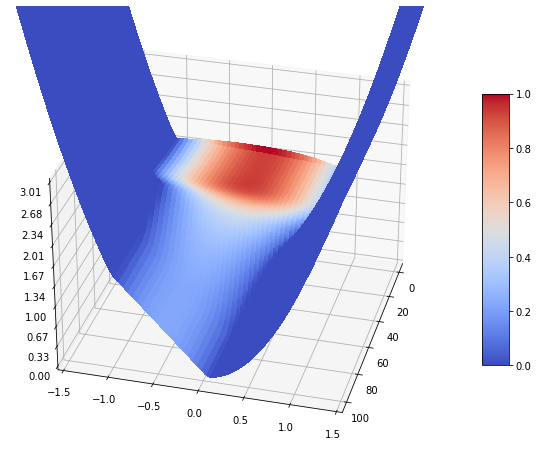

In [265]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})

# Plot the surface.
t=i
N = channel.d[t,:,:]/np.nanmax(channel.d[t,:,:])  # normalize 0..1
N[np.isnan(N)]=0.

y = np.tile(channel.y, (channel.x.size, 1))
x = np.tile(channel.x, (1, channel.y.size))
h = np.copy(channel.h)
surf = ax.plot_surface(y, x, channel.η[t, :, :], cmap=cm.coolwarm, facecolors=cm.coolwarm(N), rstride=1, cstride=1,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

# Customize the z axis.
ax.set_zlim(0, 3.01)
ax.set_ylim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax.view_init(elev=30., azim=15)

plt.show()

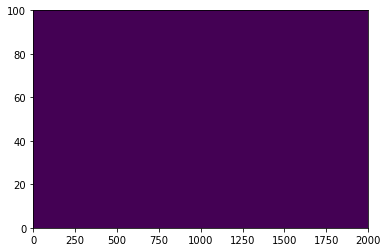

In [150]:
plt.pcolor(N)

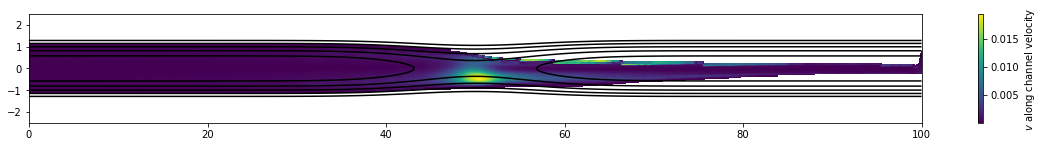

In [108]:
plt.figure(figsize=(20, 2))
q = plt.pcolor(channel.y, channel.x, (channel.qv[i,:,:]**2 + channel.qu[i,:,:]**2), cmap=plt.get_cmap("viridis"))
plt.contour(channel.y.squeeze(), channel.x.squeeze(), channel.h, levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$v$ along channel velocity')

In [ ]:
plt.figure(figsize=(20, 2))
q = plt.pcolor(channel.y, channel.x, channel.qv[i,:,:], cmap=plt.get_cmap("RdBu_r"))
plt.contour(channel.y.squeeze(), channel.x.squeeze(), channel.b, levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$v$ along channel velocity')
plt.ylim(-1.25, 1.25)
plt.xlim(40, 60)

### Polynomial fits of interface height

In [41]:
coeff_list = []

for y_idx in range(channel.y.size):

    h_avg = np.nanmean(channel.h[i-30:i, :, y_idx], axis=0)
    nan_idx = ~np.isnan(h_avg)
    α, β, γ = np.polyfit(-channel.x.squeeze()[nan_idx], h_avg[nan_idx], 2)
    
    coeff_list.append([α, β, γ])
    
coeffs = np.array(coeff_list)

/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_73807/3128962700.py:5: RuntimeWarning: Mean of empty slice
  h_avg = np.nanmean(channel.h[i-30:i, :, y_idx], axis=0)


TypeError: expected non-empty vector for x

In [33]:
zpv_coeff_list = []

for y_idx in range(channel.y.size):

    zpv_α = -2.1667
    h_avg = np.nanmean(channel.h[i-30:i, :, y_idx], axis=0) - (-2.1667 * channel.x.squeeze()**2)
    nan_idx = ~np.isnan(h_avg)
    β, γ = np.polyfit(-channel.x.squeeze()[nan_idx], h_avg[nan_idx], 1)
    
    zpv_coeff_list.append([zpv_α, β, γ])
    
zpv_coeffs = np.array(zpv_coeff_list)

/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_69480/2133648877.py:6: RuntimeWarning: Mean of empty slice
  h_avg = np.nanmean(channel.h[i-30:i, :, y_idx], axis=0) - (-2.1667 * channel.x.squeeze()**2)


### Plotting trajectories

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    print(base)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

data = np.load("../data/critical.npz")
print(data.files)
alphas = data["Alphas"]
betas = data["Betas"]
gammas = data["Gammas"]
match = data["match"]

tol = 0.50
Q = data["Q"]
c = np.logical_and(match<=1+tol, match>=1-tol)

FileNotFoundError: [Errno 2] No such file or directory: '../data/critical.npz'

In [9]:
beta_2d = betas[0,:,:]
alpha_2d = alphas[0,:,:]
gamma_2d = np.zeros_like(alpha_2d)
Q_2d = np.zeros_like(alpha_2d)

beta_coarsen = 3
alpha_coarsen = 3

for beta_idx in range(beta_2d[:,0].size):
    for alpha_idx in range(alpha_2d[0,:].size):
        
        if np.any(c[:, beta_idx, alpha_idx]):
            gamma_tmp = np.nanmean(gammas[c[:, beta_idx, alpha_idx], beta_idx, alpha_idx])
            gamma_idx = np.argmin(np.abs(gamma_tmp - gammas[:,0,0]))
            gamma_2d[beta_idx, alpha_idx] = gammas[gamma_idx,beta_idx,alpha_idx]
            Q_2d[beta_idx, alpha_idx] = Q[gamma_idx,beta_idx,alpha_idx]
        else:
            gamma_2d[beta_idx, alpha_idx] = np.nan
            Q_2d[beta_idx, alpha_idx] = np.nan

/anaconda3/envs/sarah/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
<ipython-input-10-ca4dce0c8bef>:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  sc = ax.plot_surface(alpha_2d, beta_2d, gamma_2d, facecolors=rgb)
/anaconda3/envs/sarah/lib/python3.8/site-packages/matplotlib/colors.py:278: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/anaconda3/envs/sarah/lib/python3.8/site-packages/matplotlib/colors.py:278: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


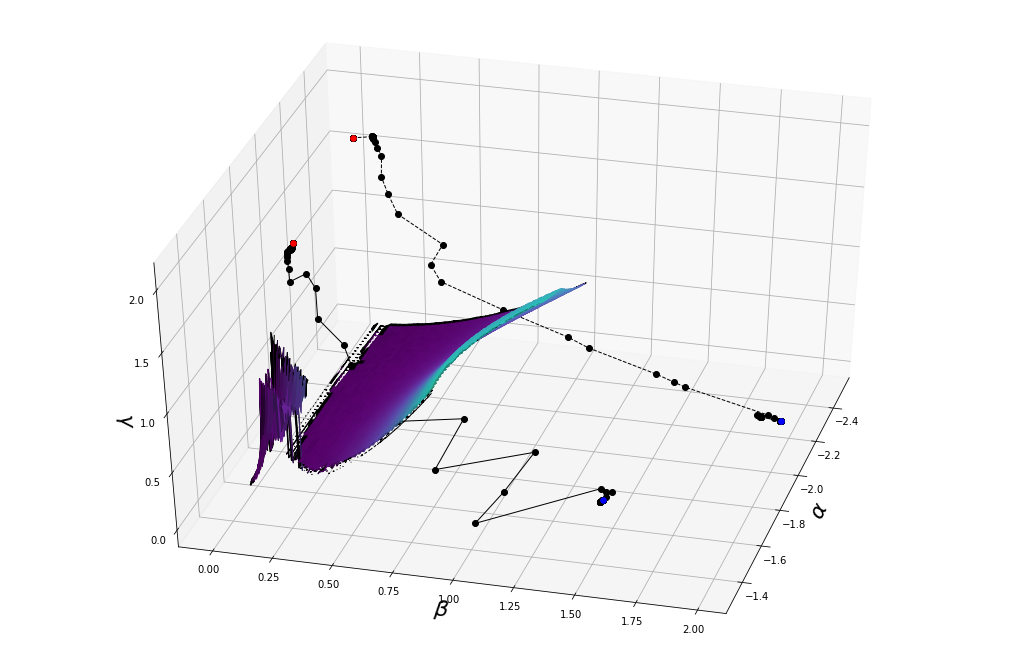

In [10]:
from matplotlib.colors import LightSource

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.gca(projection='3d')

ls = LightSource(-15, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(Q_2d, cmap=plt.get_cmap('viridis'), blend_mode='overlay', vmin=0., vmax=1.5, fraction=1.)

sc = ax.plot_surface(alpha_2d, beta_2d, gamma_2d, facecolors=rgb)

ll = ax.plot3D(coeffs[:,0], coeffs[:,1], coeffs[:,2], color='k', linewidth=1., linestyle = '-', marker = 'o', alpha=1.0)
ll = ax.scatter3D(coeffs[0,0], coeffs[0,1], coeffs[0,2], color='r', s=30., marker = 'o', alpha=1.0)
ll = ax.scatter3D(coeffs[-1,0], coeffs[-1,1], coeffs[-1,2], color='b', s=30., marker = 'o', alpha=1.0)

ll = ax.plot3D(zpv_coeffs[:,0], zpv_coeffs[:,1], zpv_coeffs[:,2], color='k', linewidth=1., linestyle = '--', marker = 'o', alpha=1.0)
ll = ax.scatter3D(zpv_coeffs[0,0], zpv_coeffs[0,1], zpv_coeffs[0,2], color='r', s=30., marker = 'o', alpha=1.0)
ll = ax.scatter3D(zpv_coeffs[-1,0], zpv_coeffs[-1,1], zpv_coeffs[-1,2], color='b', s=30., marker = 'o', alpha=1.0)

ax.set_xlabel(r'$\alpha$',fontsize=22)
ax.set_ylabel(r'$\beta$',fontsize=22)
ax.set_zlabel(r'$\gamma$',fontsize=22)

ax.view_init(40, 15)

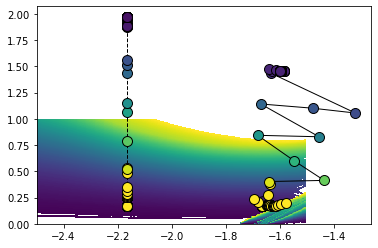

In [11]:
vmax=1.
plt.pcolormesh(alpha_2d, beta_2d, gamma_2d, cmap='viridis', vmin=0., vmax=vmax,)
vir = plt.get_cmap('viridis')

plt.plot(coeffs[:,0], coeffs[:,1], color='k', linewidth=1., linestyle = '-', alpha=1.0)
for i in range(channel.y.size):
    plt.plot(coeffs[i,0], coeffs[i,1], color=vir(coeffs[i,2]/vmax), linewidth=0., marker='o', markeredgecolor='k', markersize=10)

plt.plot(zpv_coeffs[:,0], zpv_coeffs[:,1], color='k', linewidth=1., linestyle = '--', alpha=1.0)
for i in range(channel.y.size):
    plt.plot(zpv_coeffs[i,0], zpv_coeffs[i,1], color=vir(zpv_coeffs[i,2]/vmax), linewidth=0., marker='o', markeredgecolor='k', markersize=10)


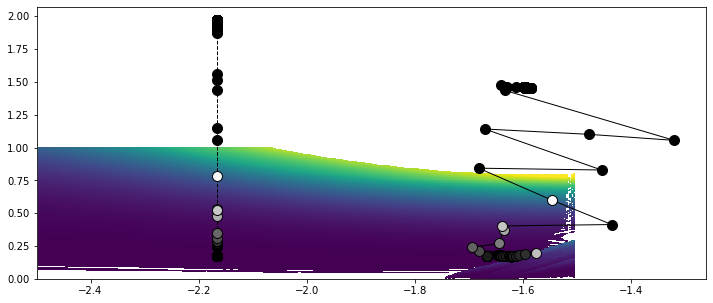

In [12]:
plt.figure(figsize=(12,5))

vmax=1.
plt.pcolormesh(alpha_2d, beta_2d, Q_2d, cmap='viridis', vmin=0., vmax=vmax,)
    
grey = plt.get_cmap('Greys')

plt.plot(coeffs[:,0], coeffs[:,1], color='k', linewidth=1., linestyle = '-', alpha=1.0)
for i in range(channel.y.size):
    alpha_idx = np.argmin(np.abs(alpha_2d[0,:] - coeffs[i,0]))
    beta_idx = np.argmin(np.abs(beta_2d[:,0] - coeffs[i,1]))
    error = np.abs(coeffs[i,2] - gamma_2d[beta_idx, alpha_idx])
    if np.isnan(error): error = 2.5
    plt.plot(coeffs[i,0], coeffs[i,1], color=grey(error/2.), linewidth=0., marker='o', markeredgecolor='k', markersize=10)

plt.plot(zpv_coeffs[:,0], zpv_coeffs[:,1], color='k', linewidth=1., linestyle = '--', alpha=1.0)
for i in range(channel.y.size):
    alpha_idx = np.argmin(np.abs(alpha_2d[0,:] - zpv_coeffs[i,0]))
    beta_idx = np.argmin(np.abs(beta_2d[:,0] - zpv_coeffs[i,1]))
    error = np.abs(zpv_coeffs[i,2] - gamma_2d[beta_idx, alpha_idx])
    if np.isnan(error) | (zpv_coeffs[i,1] >= 1.0): error = 2.5
    plt.plot(zpv_coeffs[i,0], zpv_coeffs[i,1], color=grey(error/2.), marker='o', markeredgecolor='k', markersize=10)


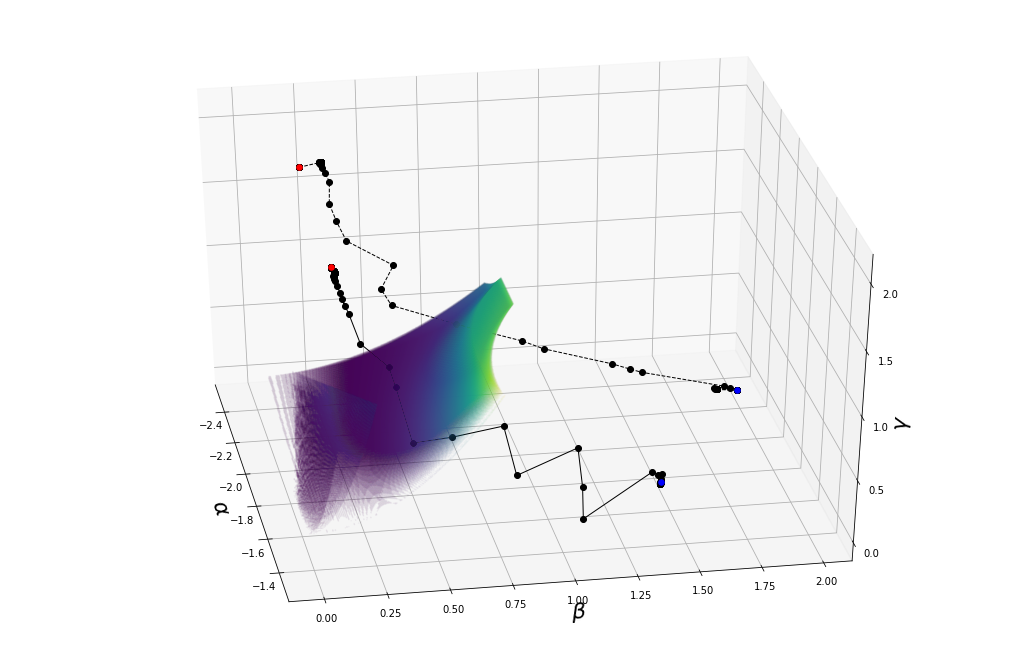

In [13]:
from matplotlib.colors import LightSource

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.gca(projection='3d')

sc = ax.scatter(xs=alphas[c].flatten(),ys=betas[c].flatten(),zs=gammas[c].flatten(),
           s=10,c=Q[c].flatten(),cmap=plt.get_cmap('viridis'),marker='.',linewidth=0,alpha=0.04)

ll = ax.plot3D(coeffs[:,0], coeffs[:,1], coeffs[:,2], color='k', linewidth=1., linestyle = '-', marker = 'o', alpha=1.0)
ll = ax.scatter(coeffs[0,0], coeffs[0,1], coeffs[0,2], color='r', s=30., marker = 'o', alpha=1.0)
ll = ax.scatter(coeffs[-1,0], coeffs[-1,1], coeffs[-1,2], color='b', s=30., marker = 'o', alpha=1.0)

ll = ax.plot3D(zpv_coeffs[:,0], zpv_coeffs[:,1], zpv_coeffs[:,2], color='k', linewidth=1., linestyle = '--', marker = 'o', alpha=1.0)
ll = ax.scatter(zpv_coeffs[0,0], zpv_coeffs[0,1], zpv_coeffs[0,2], color='r', s=30., marker = 'o', alpha=1.0)
ll = ax.scatter(zpv_coeffs[-1,0], zpv_coeffs[-1,1], zpv_coeffs[-1,2], color='b', s=30., marker = 'o', alpha=1.0)

ax.set_xlabel(r'$\alpha$',fontsize=22)
ax.set_ylabel(r'$\beta$',fontsize=22)
ax.set_zlabel(r'$\gamma$',fontsize=22)

ax.view_init(35., -10.)

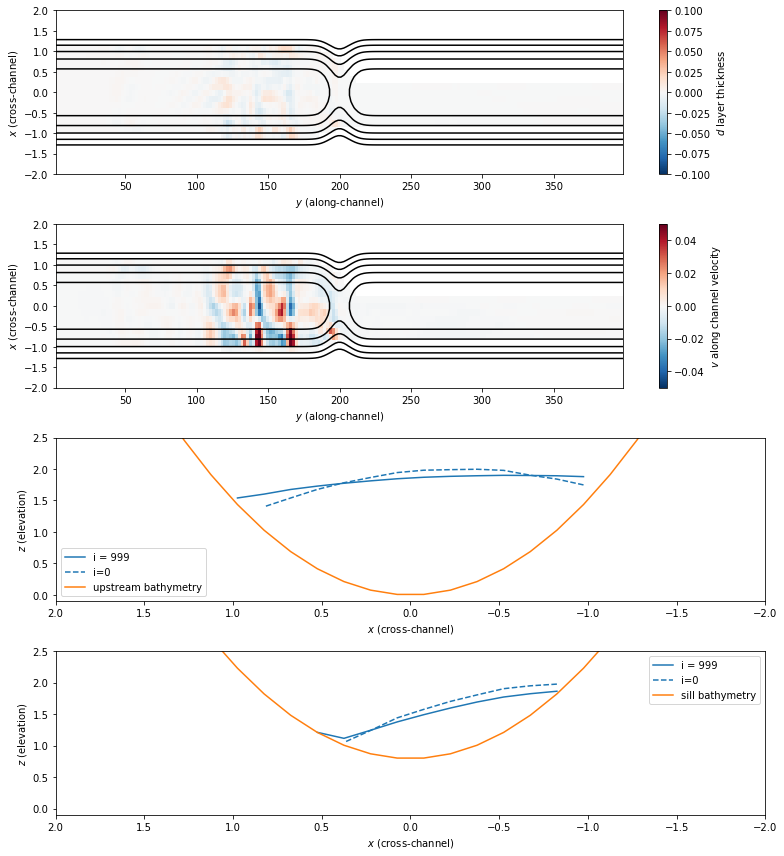

In [153]:
plt.figure(1,figsize=(11,12))
plt.clf()
plt.subplot(4,1,1)
q = plt.pcolor(channel.x,channel.y,channel.h[i,:,:]-channel.h[i-2,:,:],cmap=plt.get_cmap("RdBu_r"))
plt.contour(channel.x.squeeze(),channel.y.squeeze(),channel.b,levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$d$ layer thickness')
q.set_clim([-0.1,0.1])
plt.ylim([-2,2])
plt.ylabel(r"$x$ (cross-channel)")
plt.xlabel(r"$y$ (along-channel)")

plt.subplot(4,1,2)
q = plt.pcolor(channel.x,channel.y,channel.qu[i,:,:]-channel.qu[i-2,:,:],cmap=plt.get_cmap("RdBu_r"))
plt.contour(channel.x.squeeze(),channel.y.squeeze(),channel.b,levels=np.arange(0,3.,0.5),colors="k")
plt.colorbar(q, label=r'$v$ along channel velocity')
q.set_clim([-0.05,0.05])
plt.ylim([-2,2])
plt.ylabel(r"$x$ (cross-channel)")
plt.xlabel(r"$y$ (along-channel)")

plt.subplot(4,1,3)
nxhalf = np.int64(channel.x.size/2.)
plt.plot(channel.y,channel.h[i,:,0]+channel.b[:,0],"C0-",label=f'i = {i}')
plt.plot(channel.y,channel.h[0,:,0]+channel.b[:,0],"C0--",label='i=0')
plt.plot(channel.y,channel.b[:,0],"C1-",label='upstream bathymetry')
plt.xlim([2,-2.])
plt.ylim([-0.1,2.5])
plt.legend()
plt.xlabel(r"$x$ (cross-channel)")
plt.ylabel(r"$z$ (elevation)")
plt.tight_layout()

plt.subplot(4,1,4)
nxhalf = np.int64(channel.x.size/2.)
plt.plot(channel.y,channel.h[i,:,nxhalf]+channel.b[:,nxhalf],"C0-",label=f'i = {i}')
plt.plot(channel.y,channel.h[0,:,nxhalf]+channel.b[:,nxhalf],"C0--",label='i=0')
plt.plot(channel.y,channel.b[:,nxhalf],"C1-",label='sill bathymetry')
plt.xlim([2,-2.])
plt.ylim([-0.1,2.5])
plt.legend()
plt.xlabel(r"$x$ (cross-channel)")
plt.ylabel(r"$z$ (elevation)")
plt.tight_layout()

plt.savefig("figures_run001/faroe_bank_simulation.png", bbox_inches='tight', dpi=150.)

(-0.1, 3.0)

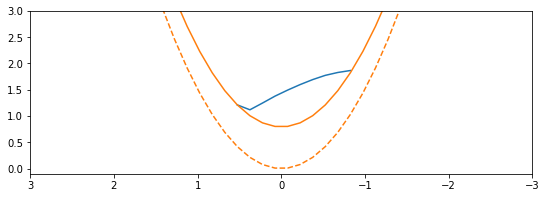

In [131]:
plt.figure(figsize=(9,3))
nxhalf = np.int64(channel.x.size/2.)
plt.plot(channel.y,channel.h[i,:,nxhalf]+channel.b[:,nxhalf],"C0-")
plt.plot(channel.y,channel.b[:,nxhalf],"C1-")
plt.plot(channel.y,channel.b[:,0],"C1--")
plt.xlim([3,-3.])
plt.ylim([-0.1,3.0])